In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import DataLoader

from roi_align.roi_align import RoIAlign      # RoIAlign module
from roi_align.roi_align import CropAndResize # crop_and_resize module
# from image_loader import Image_Reader
from torch.utils.data import DataLoader

import json
import torch
import string
import pprint
import os
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from PIL import Image

import torch._utils
try:
    torch._utils._rebuild_tensor_v2
except AttributeError:
    def _rebuild_tensor_v2(storage, storage_offset, size, stride, requires_grad, backward_hooks):
        tensor = torch._utils._rebuild_tensor(storage, storage_offset, size, stride)
        tensor.requires_grad = requires_grad
        tensor._backward_hooks = backward_hooks
        return tensor
    torch._utils._rebuild_tensor_v2 = _rebuild_tensor_v2

In [2]:
class ImageReader(Dataset):
    def __init__(self):
        self.__prepare_feat()

    def __prepare_feat(self):
        self.root_path = '/scratch/medhini2/paragraph_generation/data'
        
        train_file = open(self.root_path + '/train_split.json')
        train_l = json.load(train_file)
        test_file = open(self.root_path + '/test_split.json')
        test_l = json.load(test_file)
        val_file = open(self.root_path + '/val_split.json')
        val_l = json.load(val_file)
        self.image_files = [str(l)+'.jpg' for l in train_l] + [str(l)+'.jpg' for l in test_l] + [str(l)+'.jpg' for l in val_l]
            
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img = Image.open(os.path.join(self.root_path+'/images/',filename)).convert('RGB')
        trans = transforms.ToTensor()
        img = trans(img)
        filename = filename.split('.')[0] + '.pt'
        box = torch.load(os.path.join(self.root_path + '/boxes/', filename))
        box = torch.FloatTensor(box)
        box_idxs = torch.IntTensor([0 for i in range(len(box))])
#         print(num_box)
        #check next sentence 
#         if box_idx == 0:
#             box = torch.zeros(2,4)
        return filename, img, box, box_idxs
    
images = ImageReader()
image_data = DataLoader(dataset=images, num_workers=4, batch_size=1, shuffle=False, drop_last=False) #How to make it work for batch size >1

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)
crop_height = 7
crop_width = 7
roi_dir = '/scratch/medhini2/paragraph_generation/data/RoI_avg/'

avg_pool_crops = nn.AvgPool2d(7)
resnet152 = models.resnet152(pretrained=True)
resnet152 = resnet152.cuda()
modules = list(resnet152.children())[:-3]
resnet152 = nn.Sequential(*modules)
resnet152.eval() #ignoring dropout

for p in resnet152.parameters():
    p.requires_grad = False
    
for batch_idx, (filename, images, boxes_data, box_idxs) in enumerate(image_data):
    
    images = Variable(images, requires_grad=False).cuda()
    featuremap = resnet152(images).cuda()
    boxes = Variable(boxes_data, requires_grad=False).cuda()
    box_idxs = Variable(box_idxs, requires_grad=False).cuda()
    #RoIAlign layer
    roi_align = RoIAlign(crop_height, crop_width)
    roi_align = roi_align.cuda()
    crops = roi_align(featuremap, boxes[0], box_idxs)
    roi_file = os.path.join(roi_dir,filename[0])
    crops = avg_pool_crops(crops).view(crops.shape[0],-1)
    torch.save(crops.data,roi_file)
        

In [4]:
import numpy as np
fmap_test = Variable(torch.from_numpy(np.ones((1,1,24,32))/2.).type(torch.cuda.FloatTensor)).cuda()
# print(fmap_test)

boxes_test = np.array([0,0,20,50]*20).reshape((20,4))
boxes_test = Variable(torch.from_numpy(boxes_test).type(torch.cuda.FloatTensor), requires_grad=False).cuda()
box_index = Variable(torch.IntTensor([0,0,0]), requires_grad=False).cuda()
roi_align = RoIAlign(5, 5).cuda()
crops = roi_align(fmap_test,boxes_test, box_index)
print(crops)

Variable containing:
(0 ,0 ,.,.) = 
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

(1 ,0 ,.,.) = 
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

(2 ,0 ,.,.) = 
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  0.5000  0.5000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

(3 ,0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000

(4 ,0 ,.,.) = 
  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.000

NameError: name 'feature' is not defined

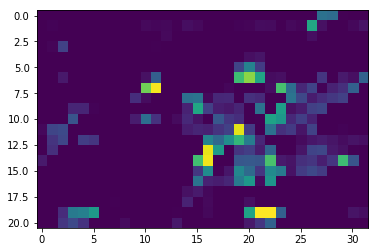

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(featuremap[0][2].data.cpu().numpy())
roi_align(feature)
# plt.imshow(featuremap[0][0].cpu().detach())

In [ ]:
import numpy as np
np.unique(featuremap[0][2].data.cpu().numpy())

In [ ]:
print(boxes.shape)

In [ ]:
boxes[0]